# Rational

The primary objective of this machine learning solution is to predict the estimated success 

# Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import load_top_1500_steam

import calendar

top_1500_steam = load_top_1500_steam()
plt.style.use('ggplot')

def perform_feature_engineering():
    # Exploring price_category vs revenue and price vs copies sold
    bins = [-1, 0, 10, 50, float('inf')]  # -1 to include 0 in the first bin
    labels = ['Free to Play', 'Under $10', '$10-50', 'Over $50']
    top_1500_steam['price_category'] = pd.cut(top_1500_steam['price'], bins=bins, labels=labels)

    top_1500_steam['release_date'] = pd.to_datetime(top_1500_steam['release_date'], format='%Y-%m-%d')
    top_1500_steam['release_month'] = top_1500_steam['release_date'].dt.month_name()
    month_order = list(calendar.month_name[1:])
    top_1500_steam['release_month'] = pd.Categorical(top_1500_steam['release_month'], categories=month_order, ordered=True)

    bins = [-1, 10, 20, 40, 50, 70, 80, 95, float('inf')] # Based on how steam categorizes
    labels = ['Overwhelmingly Negative', 'Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Positive', 'Very Positive', 'Overwhelmingly Positive']
    top_1500_steam['review_score_category'] = pd.cut(top_1500_steam['review_score'], bins=bins, labels=labels)
perform_feature_engineering()

2024-12-04 11:58:21.146 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-12-04 11:58:21.149 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-12-04 11:58:21.150 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-12-04 11:58:21.151 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-12-04 11:58:22.057 
  command:

    streamlit run c:\HW\Fall_2024_MSU\CMSE830\Homework\conman\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2024-12-04 11:58:22.059 No runtime found, using MemoryCacheStorageManager


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression

from utils import load_all_55000_steam

all_55000_steam = load_all_55000_steam()
plt.style.use('ggplot')

def perform_feature_engineering(all_55000_steam) -> pd.DataFrame:
    # Categorizing Price
    bins = [-1, 0, 10, 50, float('inf')]  # -1 to include 0 in the first bin
    labels = ['Free to Play', 'Under $10', '$10-50', 'Over $50']
    all_55000_steam['price_category'] = pd.cut(all_55000_steam['price'], bins=bins, labels=labels)

    # Creating a total review counts feature
    all_55000_steam['total_review_count'] = all_55000_steam['positive_reviews'] + all_55000_steam['negative_reviews']
    all_55000_steam['positive_ratio'] = all_55000_steam['positive_reviews'] / all_55000_steam['total_review_count']

    # Categorizing total review counts
    bins = [-1, 7, 15, 30, 60, 125, 250, 500, 1000, 2000, float('inf')]
    all_55000_steam['total_review_bins'] = pd.cut(all_55000_steam['total_review_count'], bins=bins)

    # Making "ownerss" a categorical ordinal feature
    owners_order = [
            "0 .. 20,000",
            "20,000 .. 50,000",
            "50,000 .. 100,000",
            "100,000 .. 200,000",
            "200,000 .. 500,000",
            "500,000 .. 1,000,000",
            "1,000,000 .. 2,000,000",
            "2,000,000 .. 5,000,000",
            "5,000,000 .. 10,000,000",
            "10,000,000 .. 20,000,000",
            "20,000,000 .. 50,000,000",
            "50,000,000 .. 100,000,000",
            "200,000,000 .. 500,000,000",  
        ]
    all_55000_steam['owners'] = pd.Categorical(all_55000_steam['owners'], categories=owners_order, ordered=True)

    # Converting missed datetime format "MON DD, YYYY"
    pattern_mon_day_year_comma = r'^[A-Za-z]{3} \d{1,2}, \d{4}$'  # Matches "Mon DD, YYYY" format
    mask_mon_day_year_comma = all_55000_steam['release_date'].str.match(pattern_mon_day_year_comma, na=False)
    all_55000_steam.loc[mask_mon_day_year_comma, 'release_date'] = pd.to_datetime(all_55000_steam.loc[mask_mon_day_year_comma, 'release_date'], format='%b %d, %Y')

    # Creating a new feature 'release_year' by binning on release_date
    all_55000_steam['release_date'] = pd.to_datetime(all_55000_steam['release_date'], format='%Y-%m-%d')
    all_55000_steam['release_year'] = all_55000_steam['release_date'].dt.year
    all_55000_steam['release_year'] = all_55000_steam['release_year'].astype("Int64")
    
    return all_55000_steam
all_55000_steam = perform_feature_engineering(all_55000_steam)

# The additional feature_engineering is specifically for the modeling portion of the analysis
def perform_additional_feature_engineering(all_55000_steam) -> pd.DataFrame:
    # Getting total developer and publisher experiences
    filter_terms = ["Inc", "Inc.", "LLC", "Ltd", "Ltd.", "LTD."] # The list of developers includes lots of filler stuff that throws off our count. Not all "LLC" work on the same games after all.
    
    all_55000_steam['developers'] = all_55000_steam['developers'].fillna('').astype(str)
    all_55000_steam['publishers'] = all_55000_steam['publishers'].fillna('').astype(str)

    def filter_entities(entity_list):
        return [entity for entity in entity_list if not any(term in entity for term in filter_terms)]

    all_55000_steam['developer_list'] = all_55000_steam['developers'].apply(lambda x: [dev.strip() for dev in x.split(',') if dev.strip()])
    all_55000_steam['publisher_list'] = all_55000_steam['publishers'].apply(lambda x: [dev.strip() for dev in x.split(',') if dev.strip()])

    all_55000_steam['developer_list'] = all_55000_steam['developer_list'].apply(filter_entities)
    all_55000_steam['publisher_list'] = all_55000_steam['publisher_list'].apply(filter_entities)

    developer_df = all_55000_steam[['app_id', 'developer_list']].explode('developer_list')
    publisher_df = all_55000_steam[['app_id', 'publisher_list']].explode('publisher_list')

    developer_counts = developer_df.groupby('developer_list')['app_id'].nunique().reset_index()
    developer_counts.rename(columns={'app_id': 'developer_experience'}, inplace=True)
    publisher_counts = publisher_df.groupby('publisher_list')['app_id'].nunique().reset_index()
    publisher_counts.rename(columns={'app_id': 'publisher_experience'}, inplace=True)

    developer_df = developer_df.merge(developer_counts, on='developer_list', how='left')
    publisher_df = publisher_df.merge(publisher_counts, on='publisher_list', how='left')

    dev_exp_avg = developer_df.groupby('app_id')['developer_experience'].sum().reset_index()
    all_55000_steam = all_55000_steam.merge(dev_exp_avg, on='app_id', how='left')

    pub_exp_avg = publisher_df.groupby('app_id')['publisher_experience'].sum().reset_index()
    all_55000_steam = all_55000_steam.merge(pub_exp_avg, on='app_id', how='left')

    # Exploding genres using a MultiLabelBinarizer
    all_55000_steam['genres'].fillna("", inplace=True)
    all_55000_steam['genres_list'] = all_55000_steam['genres'].str.split(', ')

    mlb = MultiLabelBinarizer()
    genres_encoded = mlb.fit_transform(all_55000_steam['genres_list'])

    genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
    all_55000_steam = pd.concat([all_55000_steam, genres_df], axis=1)
    all_55000_steam = all_55000_steam.drop('genres_list', axis=1)

    # Exploding price category using pd.get_dummies
    price_category_dummies = pd.get_dummies(all_55000_steam['price_category'], prefix='price_category')
    all_55000_steam = pd.concat([all_55000_steam, price_category_dummies], axis=1)

    all_55000_steam['languages'].fillna("", inplace=True) # if the game doesnt have it listed, then it is simply left blank.
    possible_languages = ['Afrikaans', 'Albanian', 'Arabic', 'Azerbaijani', 'Bangla', 'Basque', 'Belarusian',
                        'Bosnian', 'Bulgarian', 'Catalan', 'Croatian', 'Czech', 'Danish', 'Dari', 'Dutch',
                        'English', 'Estonian', 'Filipino', 'Finnish', 'French', 'Galician', 'Georgian',
                        'German', 'Greek', 'Hebrew', 'Hindi', 'Hungarian', 'Icelandic', 'Indonesian',
                        'Irish', 'Italian', 'Japanese', 'Kannada', 'Kazakh', 'Korean', 'Latvian',
                        'Lithuanian', 'Luxembourgish', 'Macedonian', 'Malay', 'Maori', 'Marathi',
                        'Mongolian', 'Norwegian', 'Persian', 'Polish', 'Portuguese', 'Portuguese - Brazil',
                        'Portuguese - Portugal', 'Punjabi (Gurmukhi)', 'Romanian', 'Russian',
                        'Serbian', 'Simplified Chinese', 'Slovak', 'Slovenian', 'Spanish - Latin America',
                        'Spanish - Spain', 'Swahili', 'Swedish', 'Tamil', 'Telugu', 'Thai',
                        'Traditional Chinese', 'Turkish', 'Ukrainian', 'Urdu', 'Uzbek', 'Valencian',
                        'Vietnamese', 'Welsh'] # List of languages, gotten by manually cleaning unique values of languages
                                                # Yes.. apparently Portuguese has 3 derivatives that are unique
                                                # Apparently this is true for a few of these languages. Nice to know!

    # The languages feature is turning out to be really... terrible in format
    # Tons of random \r\n tags, random BBCode and HTML tags, random parenthesis tags, we need to a ton of cleaning to extract and explode this column.
    def clean_languages(language_text):
        if pd.isnull(language_text) or language_text.strip() == '':
            return []
        language_text = language_text.replace('\r\n', ',').replace(';', ',')# Replace '\r\n' and ';' with commas
        language_text = re.sub(r'\[.*?\]', '', language_text) # Remove BBCode or HTML tags like '[b]*[/b]'
        language_text = language_text.replace('(full audio)', '').replace('Not supported', '') # Remove '(full audio)', 'Not supported'
        language_text = re.sub(' +', ' ', language_text) # Fix badly spaced language texts
        language_text = language_text.strip()

        if language_text == '':
            return []
        language_list = language_text.split(',') # Finally ready to split

        language_list = [lang.strip() for lang in language_list if lang.strip()]
        detected_languages = []
        for lang in language_list:
            matched = False
            for possible_lang in possible_languages:
                if possible_lang.lower() == lang.lower():
                    detected_languages.append(possible_lang)
                    matched = True
                    break
            if not matched:
                for possible_lang in possible_languages:
                    if possible_lang.lower() in lang.lower():
                        detected_languages.append(possible_lang)
                        break
        detected_languages = list(set(detected_languages))
        return detected_languages


    all_55000_steam['languages_cleaned'] = all_55000_steam['languages'].apply(clean_languages)
    mlb = MultiLabelBinarizer()

    languages_encoded = mlb.fit_transform(all_55000_steam['languages_cleaned'])
    languages_df = pd.DataFrame(languages_encoded, columns=mlb.classes_, index=all_55000_steam.index)

    all_55000_steam = pd.concat([all_55000_steam, languages_df], axis=1)
    all_55000_steam = all_55000_steam.drop('languages_cleaned', axis=1)
    return all_55000_steam

c:\HW\Fall_2024_MSU\CMSE830\Project\utils.py:40: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv("data/all_55000_steam.csv")


C:\Users\jie22\AppData\Local\Temp\ipykernel_31612\2178757761.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_55000_steam['genres'].fillna("", inplace=True)


C:\Users\jie22\AppData\Local\Temp\ipykernel_31612\1363526283.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_55000_steam['languages'].fillna("", inplace=True)


In [59]:
all_55000_steam.columns.values

array(['app_id', 'name', 'short_description', 'developers', 'publishers',
       'genres', 'tags', 'type', 'categories', 'owners',
       'positive_reviews', 'negative_reviews', 'price', 'initial_price',
       'discount', 'ccu', 'languages', 'platforms', 'release_date',
       'required_age', 'website', 'header_image', 'price_category',
       'total_review_count', 'positive_ratio', 'total_review_bins',
       'release_year', 'developer_list', 'publisher_list',
       'developer_experience', 'publisher_experience', '', 'Accounting',
       'Action', 'Adventure', 'Animation & Modeling', 'Audio Production',
       'Casual', 'Design & Illustration', 'Early Access', 'Education',
       'Free To Play', 'Free to Play', 'Game Development', 'Gore',
       'Indie', 'Massively Multiplayer', 'Movie', 'Nudity',
       'Photo Editing', 'RPG', 'Racing', 'Sexual Content', 'Simulation',
       'Software Training', 'Sports', 'Strategy', 'Utilities',
       'Video Production', 'Violent', 'Web Publishin

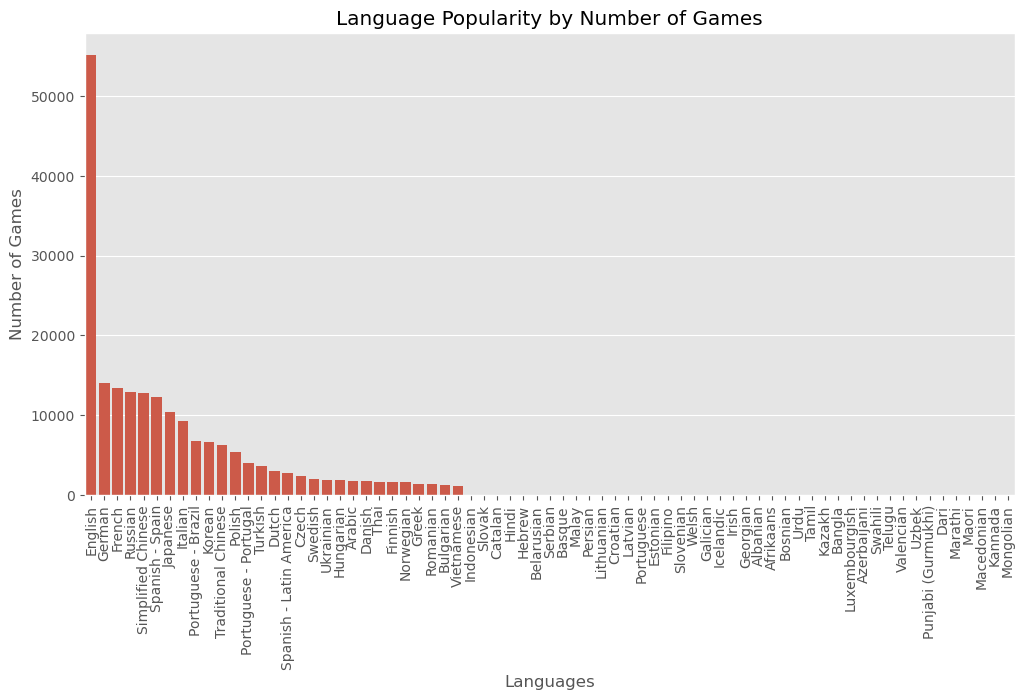

    app_id  languages_supported
0       10                    8
1  1000000                    3
2  1000010                    9
3  1000030                    1
4  1000040                    1


In [61]:
# Sum across the columns of the encoded languages to calculate the total for each language
language_popularity = languages_df.sum().sort_values(ascending=False)

# Create a histogram for language popularity
plt.figure(figsize=(12, 6))
sns.barplot(x=language_popularity.index, y=language_popularity.values)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Language Popularity by Number of Games')
plt.xlabel('Languages')
plt.ylabel('Number of Games')
plt.show()

# Feature encode a new feature "languages_supported"
all_55000_steam['languages_supported'] = languages_df.sum(axis=1)

# Inspect the new feature
print(all_55000_steam[['app_id', 'languages_supported']].head())

In [63]:
all_55000_steam.info()
all_55000_steam.columns.values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55691 entries, 0 to 55690
Columns: 137 entries, app_id to languages_supported
dtypes: Int64(1), bool(4), category(3), datetime64[ns](1), float64(5), int32(101), int64(7), object(15)
memory usage: 34.2+ MB


array(['app_id', 'name', 'short_description', 'developers', 'publishers',
       'genres', 'tags', 'type', 'categories', 'owners',
       'positive_reviews', 'negative_reviews', 'price', 'initial_price',
       'discount', 'ccu', 'languages', 'platforms', 'release_date',
       'required_age', 'website', 'header_image', 'price_category',
       'total_review_count', 'positive_ratio', 'total_review_bins',
       'release_year', 'developer_list', 'publisher_list',
       'developer_experience', 'publisher_experience', '', 'Accounting',
       'Action', 'Adventure', 'Animation & Modeling', 'Audio Production',
       'Casual', 'Design & Illustration', 'Early Access', 'Education',
       'Free To Play', 'Free to Play', 'Game Development', 'Gore',
       'Indie', 'Massively Multiplayer', 'Movie', 'Nudity',
       'Photo Editing', 'RPG', 'Racing', 'Sexual Content', 'Simulation',
       'Software Training', 'Sports', 'Strategy', 'Utilities',
       'Video Production', 'Violent', 'Web Publishin

In [ ]:
columns = list(all_55000_steam.columns)

idx_empty_string = columns.index('') # We have an empty string column for genre since some games don't have a genre attached
idx_price_category_start = columns.index('price_category_Free to Play')
idx_language_start = columns.index('Afrikaans')
idx_languages_supported = columns.index('languages_supported')


genres_columns = columns[idx_empty_string:idx_price_category_start]
price_category_columns = columns[idx_price_category_start:idx_language_start]
languages_columns = columns[idx_language_start:idx_languages_supported]

# Additional features (confounders)
additional_features = ['developer_experience', 'publisher_experience', 'languages_supported']
feature_columns = price_category_columns + additional_features + genres_columns + languages_columns
# Target
target_column = 'total_review_count'

In [ ]:
data = all_55000_steam[feature_columns + [target_column]]
print(data.shape)
print(data.columns.values)

# Separate features and target
X = data[feature_columns]
y = data[target_column]
# X = scaler.fit_transform(X)
# y = np.log1p(y)

(55691, 110)
['price_category_Free to Play' 'price_category_Under $10'
 'price_category_$10-50' 'price_category_Over $50' 'developer_experience'
 'publisher_experience' 'languages_supported' 'positive_reviews' ''
 'Accounting' 'Action' 'Adventure' 'Animation & Modeling'
 'Audio Production' 'Casual' 'Design & Illustration' 'Early Access'
 'Education' 'Free To Play' 'Free to Play' 'Game Development' 'Gore'
 'Indie' 'Massively Multiplayer' 'Movie' 'Nudity' 'Photo Editing' 'RPG'
 'Racing' 'Sexual Content' 'Simulation' 'Software Training' 'Sports'
 'Strategy' 'Utilities' 'Video Production' 'Violent' 'Web Publishing'
 'Afrikaans' 'Albanian' 'Arabic' 'Azerbaijani' 'Bangla' 'Basque'
 'Belarusian' 'Bosnian' 'Bulgarian' 'Catalan' 'Croatian' 'Czech' 'Danish'
 'Dari' 'Dutch' 'English' 'Estonian' 'Filipino' 'Finnish' 'French'
 'Galician' 'Georgian' 'German' 'Greek' 'Hebrew' 'Hindi' 'Hungarian'
 'Icelandic' 'Indonesian' 'Irish' 'Italian' 'Japanese' 'Kannada' 'Kazakh'
 'Korean' 'Latvian' 'Lithuanian'

In [190]:
# Split data into training and testing sets
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1111)

# Initialize the model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)

# Predict on test data
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression MSE:", mse_lr)
print("Linear Regression R^2:", r2_lr)

Linear Regression MSE: 2502461.5066342084
Linear Regression R^2: 0.9963511911154799


In [191]:
# Initialize the model
from sklearn.tree import DecisionTreeRegressor


dt_model = DecisionTreeRegressor(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Predict on test data
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("Decision Tree MSE:", mse_dt)
print("Decision Tree R^2:", r2_dt)

Decision Tree MSE: 24330067.132804416
Decision Tree R^2: 0.9645246231041733


In [194]:
# Initialize the model
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest MSE:", mse_rf)
print("Random Forest R^2:", r2_rf)

Random Forest MSE: 10145158.680015698
Random Forest R^2: 0.9852074667169223


In [192]:
import xgboost as xgb
# Initialize the model
xgb_model = xgb.XGBRegressor(random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost MSE:", mse_xgb)
print("XGBoost R^2:", r2_xgb)

XGBoost MSE: 515514556.0494893
XGBoost R^2: 0.24833446741104126


In [195]:
# Random Forest feature importance
importances_rf = rf_model.feature_importances_
feature_importance_rf = pd.Series(importances_rf, index=feature_columns).sort_values(ascending=False)

print("Random Forest Feature Importances:")
print(feature_importance_rf.head(10))

# XGBoost feature importance
importances_xgb = xgb_model.feature_importances_
feature_importance_xgb = pd.Series(importances_xgb, index=feature_columns).sort_values(ascending=False)

print("XGBoost Feature Importances:")
print(feature_importance_xgb.head(10))

Random Forest Feature Importances:
positive_reviews            0.990935
Massively Multiplayer       0.001727
Arabic                      0.001425
languages_supported         0.001249
Thai                        0.000532
Ukrainian                   0.000482
price_category_Under $10    0.000440
price_category_$10-50       0.000401
Indie                       0.000324
publisher_experience        0.000298
dtype: float64
XGBoost Feature Importances:
positive_reviews         0.252262
Vietnamese               0.122902
Thai                     0.094022
Bulgarian                0.083776
Finnish                  0.055067
Arabic                   0.042343
Portuguese - Portugal    0.041674
Ukrainian                0.036035
Free to Play             0.025766
Turkish                  0.022990
dtype: float32


In [196]:
from sklearn.inspection import permutation_importance

# For Random Forest
perm_importance_rf = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)

# For XGBoost
perm_importance_xgb = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42)

In [197]:
# Random Forest
perm_importance_rf_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance_Mean': perm_importance_rf.importances_mean
})

genre_perm_importance_rf = perm_importance_rf_df[perm_importance_rf_df['Feature'].isin(genres_columns)]
genre_perm_importance_rf = genre_perm_importance_rf.sort_values(by='Importance_Mean', ascending=False)

print("Random Forest Genre Permutation Importances:")
print(genre_perm_importance_rf.head(10))

# XGBoost
perm_importance_xgb_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance_Mean': perm_importance_xgb.importances_mean
})

genre_perm_importance_xgb = perm_importance_xgb_df[perm_importance_xgb_df['Feature'].isin(genres_columns)]
genre_perm_importance_xgb = genre_perm_importance_xgb.sort_values(by='Importance_Mean', ascending=False)

print("XGBoost Genre Permutation Importances:")
print(genre_perm_importance_xgb.head(10))


Random Forest Genre Permutation Importances:
                  Feature  Importance_Mean
22                  Indie     1.163973e-03
19           Free to Play     9.079522e-04
23  Massively Multiplayer     8.382185e-04
16           Early Access     3.215676e-05
14                 Casual     1.934449e-05
33               Strategy     7.387879e-06
10                 Action     5.150358e-06
27                    RPG     4.909111e-06
32                 Sports     4.715023e-06
36                Violent     3.167550e-08
XGBoost Genre Permutation Importances:
                  Feature  Importance_Mean
14                 Casual     8.421007e-02
11              Adventure     2.998387e-02
23  Massively Multiplayer     5.481911e-03
22                  Indie     4.531497e-03
16           Early Access     1.470077e-03
30             Simulation     1.312995e-03
10                 Action     7.470727e-04
28                 Racing     9.912252e-06
8                             9.572506e-06
12   Animatio